# 10. 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge

## 데이터 전처리

In [1]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(732832, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [2]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732832 entries, 0 to 732831
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   train_id           732832 non-null  int64  
 1   name               732832 non-null  object 
 2   item_condition_id  732832 non-null  int64  
 3   category_name      729689 non-null  object 
 4   brand_name         420308 non-null  object 
 5   price              732832 non-null  float64
 6   shipping           732832 non-null  int64  
 7   item_description   732830 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 44.7+ MB
None


<ipython-input-3-09c400329c8c>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_df, kde=False)


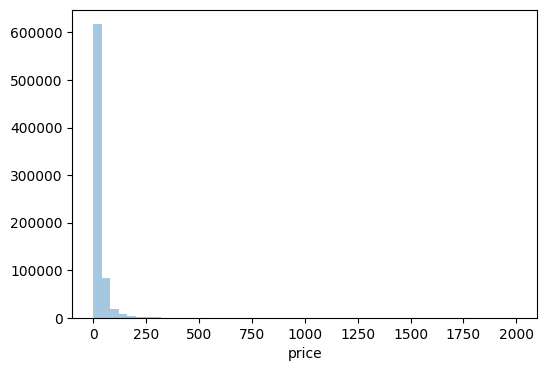

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df, kde=False)
plt.show()

price 값이 왜곡된 분포를 보이고 있음

<ipython-input-4-061981c41271>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_df, kde=False)


<Axes: xlabel='price'>

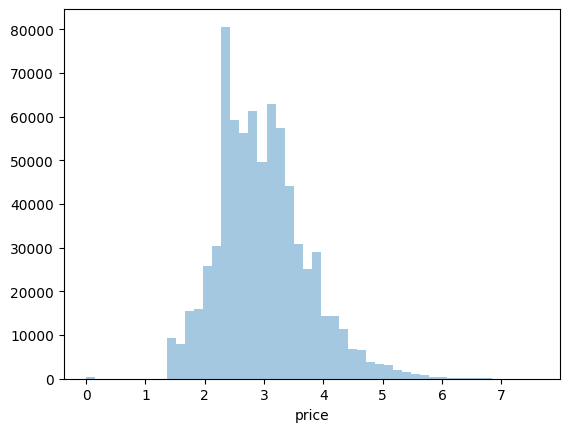

In [4]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

로그 값으로 변환하면 price 값이 비교적 정규 분포에 가까운 데이터를 이루게 됨

-> price 칼럼을 원래 값에서 로그로 변환된 값으로 변경

In [5]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


In [7]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('\n')
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 shipping
0    405380
1    327452
Name: count, dtype: int64


item_condition_id 값 유형:
 item_condition_id
1    316594
3    213624
2    185690
4     15729
5      1195
Name: count, dtype: int64


In [8]:
boolean_cond = mercari_df['item_description']=='No description yet'
mercari_df.loc[boolean_cond]['item_description'].count()

40874

'No description yet'의 경우 Null과 마찬가지로 적절한 값으로 변경해야 함

category_name은 '/'로 분리된 카테고리를 하나의 문자열로 나타내고 있음

-> '/'를 기준으로 단어를 토큰화하여 각각 별도의 피처로 저장하고 알고리즘 학습

In [9]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
  zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형:\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수:\n', mercari_df['cat_jung'].nunique())
print('소분류 개수:\n', mercari_df['cat_so'].nunique())

대분류 유형:
 cat_dae
Women                     328238
Beauty                    103021
Kids                       84603
Electronics                60814
Men                        46208
Home                       33707
Vintage & Collectibles     23033
Other                      22562
Handmade                   15155
Sports & Outdoors          12348
Other_Null                  3143
Name: count, dtype: int64
중분류 개수:
 114
소분류 개수:
 845


In [10]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야 함
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


## 피처 인코딩과 피처 벡터화

- 선형 회귀의 경우 원-핫 인코딩 적용이 선호되므로 인코딩할 피처는 모두 원-핫 인코딩 적용
- 짧은 텍스트는 Count 기반 벡터화 적용
- 긴 텍스트는 TF-IDF 기반 벡터화 적용

In [11]:
print('brand name 의 유형 건수:', mercari_df['brand_name'].nunique())
print('brand name sample 5건:\n', mercari_df['brand_name'].value_counts()[:5])

brand name 의 유형 건수: 3971
brand name sample 5건:
 brand_name
Other_Null           312524
PINK                  26596
Nike                  26383
Victoria's Secret     23867
LuLaRoe               15248
Name: count, dtype: int64


명료한 문자열로 이루어졌기 때문에 인코딩 변환 적용

In [12]:
print('name의 종류 개수:', mercari_df['name'].nunique())
print('name sample 7건:\n', mercari_df['name'].value_counts()[:7])

name의 종류 개수: 632654
name sample 7건:
 name
Bundle                 1128
Reserved                226
Dress                   212
BUNDLE                  207
Converse                207
Coach purse             187
Lularoe TC leggings     183
Name: count, dtype: int64


Name 속성은 유형이 매우 많고, 적은 단어 위주의 텍스트 형태이기 때문에 **Count 기반 피처 벡터화** 변환 적용

category_name 칼럼은 **원-핫 인코딩** 적용

shipping 칼럼과 item_condition_id는 **원-핫 인코딩** 적용

In [13]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())
mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.75736048644163


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


item_description은 **TF-IDF 피처 벡터화** 적용

In [14]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (732832, 71848)
item_description vectorization shape: (732832, 50000)


CountVectorizer, TfidfVectorizer가 fit_transform()을 통해 반호나하는 데이터는 **희소 행렬** 형태이다

-> X_name, X_descp와 결합돼 ML 모델을 실행하는 기반 데이터 세트로 재구성돼야 한다

이를 위해 인코딩 대상 칼럼도 밀집 행렬 형태가 아닌 희소 행렬 형태로 인코딩 적용 후 함께 결합

- LabelBinarizer 클래스: 희소 행렬 형태의 원-핫 인코딩 변환 지원(sparse_out=True 설정)
- hstack( ): 희소 행렬을 칼럼 레벨로 결합

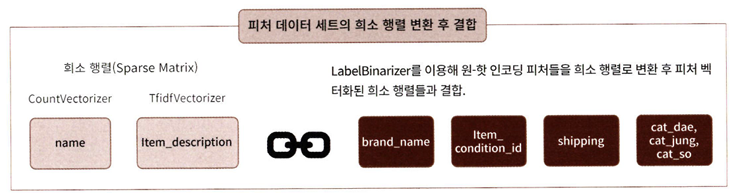

In [16]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand type:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping type:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung type:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand type:(732832, 3971), X_item_cond_id shape:(732832, 5)
X_shipping type:(732832, 1), X_cat_dae shape:(732832, 11)
X_cat_jung type:(732832, 114), X_cat_so shape:(732832, 845)


hstack( )을 이용해 데이터 세트 결합

In [17]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (732832, 126795)


192

## 릿지 회귀 모델 구축 및 평가

RMSLE: RMSE와 유사하짐나 오류 값에 로그를 취해 RMSE를 구하는 방식

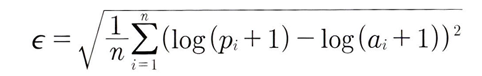

In [18]:
def rmsle(y, y_pred):
  # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
  # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)

  # rmsle로 RMSLE 값 추출
  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

In [22]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
  # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
  X = hstack(matrix_list).tocsr()

  X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'],
                                                      test_size=0.2, random_state=156)

  # 모델 학습 및 예측
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  del X, X_train, X_test, y_train
  gc.collect()

  return preds, y_test

Ridge를 이용해 Mercari Price의 회귀 예측 수행

In [23]:
linear_model = Ridge(solver='lsqr', fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5018025565350489
Item Description을 포함한 rmsle 값: 0.4747167637960075


## LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

In [24]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:', evaluate_org_price(y_test, lgbm_preds))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1002.846300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1057637
[LightGBM] [Info] Number of data points in the train set: 586265, number of used features: 60143
[LightGBM] [Info] Start training from score 2.977884


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM rmsle 값: 0.46951542501240834


In [25]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4541779959721133
